In [62]:
import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm

In [46]:
plt.style.use('ggplot')

In [7]:
file_path = '../data/coordinates.csv'
coordinates_df = pd.read_csv(file_path)

coordinates_df.head()

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684
1,1,1.2,-37.609,5.885,-6.684
2,1,1.3,-37.609,-7.315,-6.684
3,1,1.4,-25.359,-7.315,-6.684
4,2,2.1,-25.359,37.335,-6.684


In [37]:
c = 299792458 / 1e9
theta_deg = 21.315512721778354
phi_deg = 266.0685153622703

# Convert angles to radians
theta_rad = np.radians(theta_deg)
phi_rad = np.radians(phi_deg)

n_x = np.sin(theta_rad) * np.cos(phi_rad)
n_y = np.sin(theta_rad) * np.sin(phi_rad)
n_z = np.cos(theta_rad)
normal_vector = -np.array([n_x, n_y, n_z])

In [ ]:
def calculate_time_differences(df, normal_vector):
    # Extract coordinates as numpy array
    coordinates = df[['X', 'Y', 'Z']].values

    dot_products = np.dot(coordinates, normal_vector)
    sorted_indices = np.argsort(dot_products)
    sorted_stations = df.iloc[sorted_indices]
    sorted_coordinates = coordinates[sorted_indices]
    time_differences = np.diff(dot_products[sorted_indices]) / c

    # Create a result DataFrame
    results = pd.DataFrame({
        'station': sorted_stations['station'].values,
        'cluster': sorted_stations['cluster'].values,
        'X': sorted_stations['X'].values,
        'Y': sorted_stations['Y'].values,
        'Z': sorted_stations['Z'].values,
        'time_since_first_station_ns': np.concatenate(([0], np.cumsum(time_differences)))
    })

    return results

In [39]:
time_results_df = calculate_time_differences(coordinates_df, normal_vector)

In [40]:
display(time_results_df[time_results_df['cluster'] == 1])

,station,cluster,X,Y,Z,time_since_first_station_ns
10,1.3,1,-37.609,-7.315,-6.684,44.850777
11,1.4,1,-25.359,-7.315,-6.684,45.869174
16,1.2,1,-37.609,5.885,-6.684,60.818338
17,1.1,1,-25.359,5.885,-6.684,61.836735


In [41]:
events_df = pd.read_csv('../data/run_events.csv')
events_df.head()

,NRUN,NEvent,Theta,Phi,event_time_ns,clusters_bit,clusters,1_1_t,1_2_t,1_3_t,...,8_theta,8_phi,8_a_x,8_a_y,8_a_z,9_theta,9_phi,9_a_x,9_a_y,9_a_z
0,836,6627,63.67,116.71,41539852841490,254,"7,2,5,3,4,8,6",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,836,12188,42.90,198.78,41927414340004,348,"9,3,7,4,5",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,68.897595,190.808834,-0.916387,-0.174957,0.360036
2,836,12453,51.32,212.71,41946132622518,151,"1,3,2,8,5",2376.449,2347.995,2335.962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,836,31010,44.25,234.01,43256194340235,44,"6,3,4",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,836,71181,41.01,139.26,46120750960920,447,"2,1,3,9,5,4,6,8",2352.727,2340.497,2355.610,...,41.388629,136.938436,-0.483059,0.451431,0.750242,40.300258,138.166407,-0.481916,0.431391,0.762665


In [ ]:
theta_min = events_df['Theta'].min()
theta_max = events_df['Theta'].max()
phi_min = events_df['Phi'].min()
phi_max = events_df['Phi'].max()

(theta_min, theta_max), (phi_min, phi_max)

((40.0, 81.72), (105.0, 254.98))

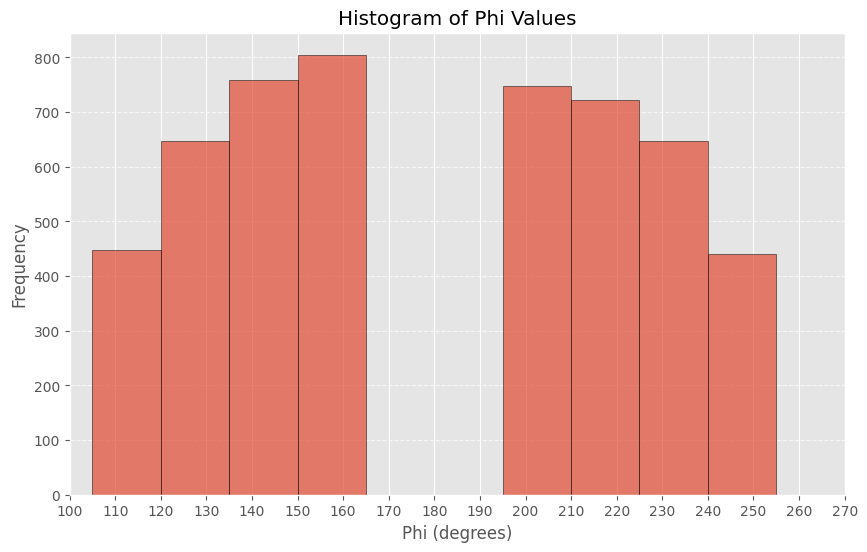

In [52]:
plt.figure(figsize=(10, 6))
plt.hist(events_df['Phi'], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Phi (degrees)')
plt.xlim(100, 270)
plt.xticks(np.arange(100, 271, 10))
plt.ylabel('Frequency')
plt.title('Histogram of Phi Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
phi_values1 = [100, 170]
phi_values2 = [190, 260]
theta_values = [30, 80]

In [84]:
columns_to_check_dynamic = [
    f"{i}_{j}_t" for i in range(1, 10) for j in range(1, 5)]

columns_to_check_dynamic = [
    col for col in columns_to_check_dynamic if col in events_df.columns]

valid_rows_mask_dynamic = events_df[columns_to_check_dynamic].notna().sum(
    axis=1) >= 3

clear_events_df = events_df[valid_rows_mask_dynamic]

len(clear_events_df)

4832

In [53]:
c = 299792458 / 1e9